# Maximum Likelihood Estimation

In [1]:
import numpy as np
from numpy.random import default_rng, Generator
from plotly import colors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import torch
from torch.optim import Optimizer, SGD
from torch.distributions.distribution import Distribution
from torch.distributions.cauchy import Cauchy

## Model
Signals $s_{t, 1}$, $s_{t, 2}$ are generated from an independent Cauchy distribution.
$$
\begin{aligned}
    s_{t, 1} & \sim \rm{Cauchy} \left( 0, 1 \right) \\
    s_{t, 2} & \sim \rm{Cauchy} \left( 0, 1 \right)
\end{aligned}
$$

We observe linear mixtures $x_{t, 1}$, $x_{t, 2}$.
$$
\begin{aligned}
    x_{t, 1} & = a_{1,1}s_{t, 1} + a_{1, 2}s_{t, 2} \\
    x_{t, 2} & = a_{2,1}s_{t, 1} + a_{1, 2}s_{t, 2}
\end{aligned}
$$

The mixture coefficients $a_{1, 1}$, $a_{1, 1}$, $a_{2, 1}$, $a_{2, 2}$ are generated from an independent Gaussian distribution.
$$
    a_{i, j} \sim \rm{Gauss}\left( 0, 1 \right),\ \rm{for}\ i\ \in\ \left\{ 1, 2 \right\},\ j\ \in \left\{ 1, 2 \right\}
$$

## Inference
We try to estimate the signals $s_{t,1}$, $s_{t,2}$ as linear combinations of the observations $x_{t, 1}$, $x_{t, 2}$.

$$
\begin{aligned}
    y_{t, 1} & = w_{1, 1}x_{t, 1} + w_{1, 2}x_{t,2} \\
    y_{t, 2} & = w_{2, 1}x_{t, 1} + w_{2, 2}x_{t, 2}
\end{aligned}
$$

Assume we know the distribution of signals.
We can calculate likelihood:
$$
\log p\left( y_{t, 1}, y_{t, 2} \right) = \log \rm{Cauchy}\left( y_{t, 1}; 0, 1 \right) + \log \rm{Cauchy} \left( y_{t, 2}; 0, 1\right)
$$

We minimize loss:

$$
\rm{Loss}\left( W \right) = - \log \rm{Cauchy}\left( y_{t, 2}; 0, 1 \right) - \log \rm{Cauchy} \left( y_{t, 2}; 0, 1\right) - \log \left| \det W \right|
$$

In [2]:
class GenerativeModel:
    a: np.ndarray
    g: Generator

    def __init__(self, g: Generator):
        self.a = g.standard_normal((2, 2))
        self.g = g

    def signal(self, size: int) -> np.ndarray:
        return self.g.standard_cauchy((size, 2))

    def mix(self, x: np.ndarray) -> np.ndarray:
        return np.dot(self.a, x.T).T


class Inference:
    w: torch.Tensor
    d: Distribution
    g: Generator
    o: Optimizer

    def __init__(self, g: Generator):
        self.w = torch.tensor(g.standard_normal((2, 2)), requires_grad=True)
        self.d = Cauchy(torch.tensor([0, 0]), torch.tensor([1, 1]))
        self.g = g
        self.o = SGD([self.w], lr=0.01, momentum=0.9)

    def update(self, x: np.ndarray) -> None:
        self.o.zero_grad()
        loss = self.loss(x)
        loss.backward()
        self.o.step()

    def loss(self, x: np.ndarray) -> torch.Tensor:
        z = self.w.matmul(torch.from_numpy(x.T))
        return -self.d.log_prob(z.T).mean(0).sum() - torch.log(
            torch.abs(torch.det(self.w))
        )


In [3]:
def attempt(g: Generator) -> None:
    gm = GenerativeModel(g)
    ifr = Inference(g)

    s = gm.signal(1000)
    x = gm.mix(s)

    for _ in range(1000):
        ifr.update(x)

    fig = make_subplots(cols=2)

    y = np.dot(ifr.w.detach().numpy(), x.T).T

    c = colors.DEFAULT_PLOTLY_COLORS

    for i in range(s.shape[1]):
        pos = {
            "row": 1,
            "col": i + 1,
        }
        opts = {"mode": "markers", "legendgroup": i, "showlegend": i == 0}

        m = lambda j: go.scatter.Marker(color=c[j])

        fig.add_trace(
            go.Scatter(
                x=s[:50, i], y=y[:50, 0], marker=m(0), name="estimation 1", **opts
            ),
            **pos,
        )
        fig.add_trace(
            go.Scatter(
                x=s[:50, i], y=y[:50, 1], marker=m(1), name="estimation 2", **opts
            ),
            **pos,
        )
        fig.add_trace(
            go.Scatter(x=s[:50, i], y=x[:50, 0], marker=m(2), name="mixture 1", **opts),
            **pos,
        )
        fig.add_trace(
            go.Scatter(x=s[:50, i], y=x[:50, 1], marker=m(3), name="mixture 2", **opts),
            **pos,
        )
        fig.update_xaxes(range=[-6, 6], title=f"signal {i+1}", **pos)
        fig.update_yaxes(range=[-6, 6], **pos)

    fig.show("png")


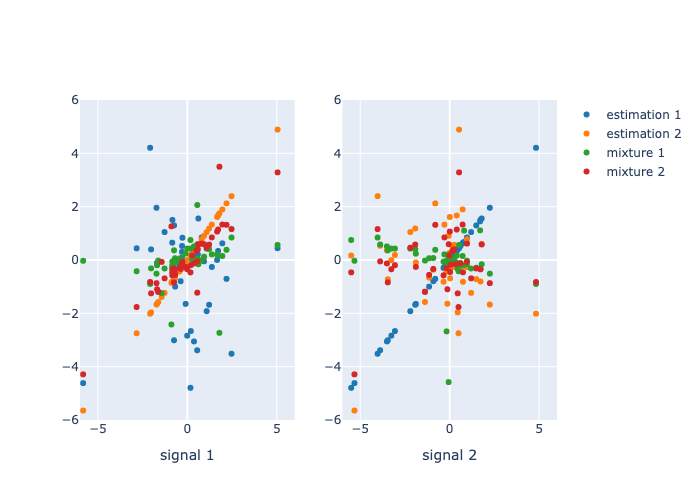

In [4]:
attempt(default_rng(0))

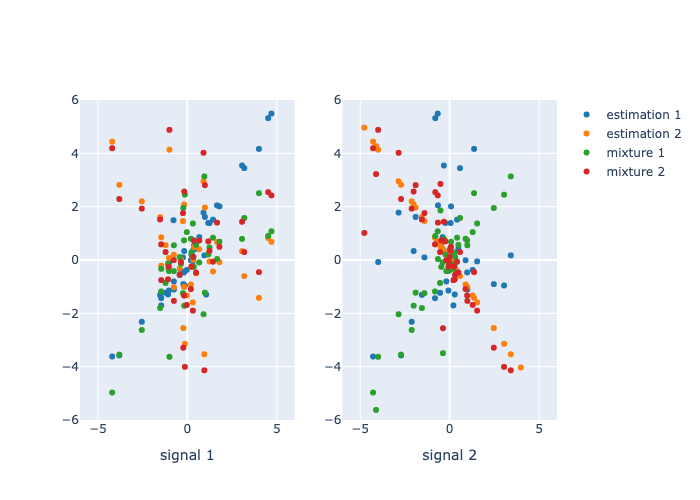

In [5]:
attempt(default_rng(1))

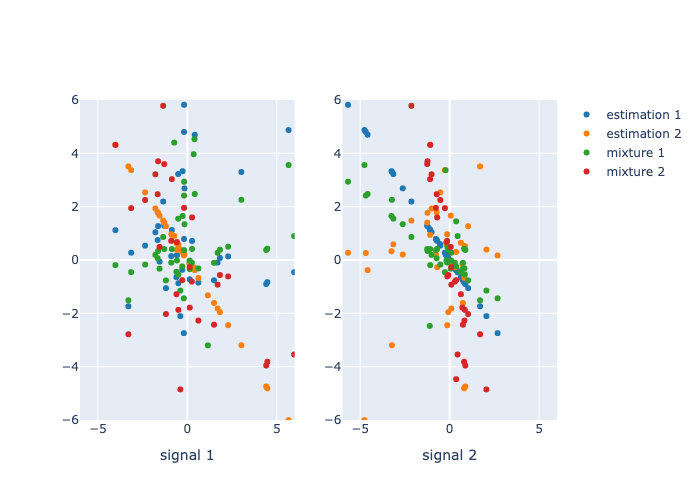

In [6]:
attempt(default_rng(2))

## References
- [Independent Component Analysis: Algorithms and Applications](https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf)